In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from qiskit_optimization.applications.vertex_cover import VertexCover
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from typing import Dict, List, Optional, Union
from docplex.mp.model import Model
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.problems.quadratic_program import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications.graph_optimization_application import GraphOptimizationApplication
from qiskit_optimization.applications import VertexCover
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def select_heroes(size):
    return dict(item for cnt, item in enumerate({
        'MEDUSA/MEDUSALITH AM': 0,
        'ARCLIGHT/PHILLIPA SO': 1,
        'WOLVERINE/LOGAN ': 2,
        'SCARLET WITCH/WANDA ': 3,
        'ARAGORN': 4,
        'OVERMIND/GROM': 5,
        'BATTLEAXE/': 6,
        'ION/': 7,
        'PINK PEARL/': 8,
        "BLACK PANTHER/T'CHAL": 9,
        'PRINCESS ZANDA': 10,
        'INFERNO III/SAMANTHA': 11,
        'MOTHER NIGHT/SUSAN S': 12,
        'VIPER II': 13,
        'IRON MAIDEN/': 14,
        'CARNIVORE/COUNT ANDR': 15,
        'HULK III/BRUCE BANNE': 16,
        'DEADPOOL/JACK/WADE W': 17,
        'BLIND AL/ALTHEA': 18,
        'WEASEL/JACK HAMMER': 19,
        'MONTGOMERY': 20}.items()) if cnt < size)

In [16]:
def use_network(size, select_heroes=select_heroes):
    data = pd.read_csv('data/hero_network.csv')
    heroes = select_heroes(size)
    
    # filter the relations from the raw data
    relations = data[(data.hero1.isin(heroes.keys())) & (data.hero2.isin(heroes.keys()))]
    relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns)
    
    # build unique relations with counts
    relations['relation'] = [' − '.join(x) for x in np.sort(relations.to_numpy(), axis=1)]
    summed_relations = relations.groupby(['relation']).size().reset_index().rename(columns={0:'count'})
    summed_relations = pd.merge(summed_relations, relations, on='relation', how='right').drop_duplicates(subset=['hero1', 'hero2'])
    
    # count the overall appearences of the heroes
    count_series1 = data.groupby(['hero1']).size()
    count_series2 = data.groupby(['hero2']).size()
    appearences = count_series1.add(count_series2, fill_value=0)
    
    # create the graph
    graph = nx.Graph()
    graph.add_nodes_from(heroes.values())
    graph.add_edges_from([(
        heroes[rel[1][2]],
        heroes[rel[1][3]]
    ) for rel in summed_relations.iterrows()])

    # add node weight
    for hero in heroes:
        graph.nodes[heroes[hero]]["weight"] = appearences[hero]
        graph.nodes[heroes[hero]]["name"] = hero

    # add edge weights
    edge_weights = dict(((heroes[rel[1][2]], heroes[rel[1][3]]),rel[1][1]) for rel in summed_relations.iterrows())
    nx.set_edge_attributes(graph, edge_weights, "connections")
    return graph

In [4]:
from qiskit_optimization.applications import GraphPartition

graph_partition = GraphPartition(use_network(8))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator"))))

result = qaoa_optimizer.solve(graph_partition.to_quadratic_program())

print("solution:", graph_partition.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [[1, 2, 6, 7], [0, 3, 4, 5]]
time: 45.36730146408081


In [5]:
def draw_graph(graph, solution=None, seed=None):
    labels = dict( (key, f"{key}−{val:.0f}") for (key, val) in nx.get_node_attributes(graph, 'weight').items())
    edge_labels = nx.get_edge_attributes(graph, 'connections')
    
    plt.figure(1,figsize=(22,8))
    plt.tight_layout()
    plt.subplots_adjust(bottom=-.5, right=0.5, left=-.5)
    node_color = ["blue" if solution[-1-i] == '0' else "yellow" for i in range(len(solution))] if solution is not None else "#ABABAB"
    
    pos = nx.spring_layout(graph, seed=seed)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=node_color, node_size=1600)
    
    nx.draw_networkx_edges(graph, pos, width=4, edge_color ="red")
    nx.draw_networkx_labels(graph,pos=pos, labels=labels, font_color="black",font_size=20)
    nx.draw_networkx_edge_labels(graph, edge_labels=edge_labels, pos=pos, font_size = 14)
    plt.show()

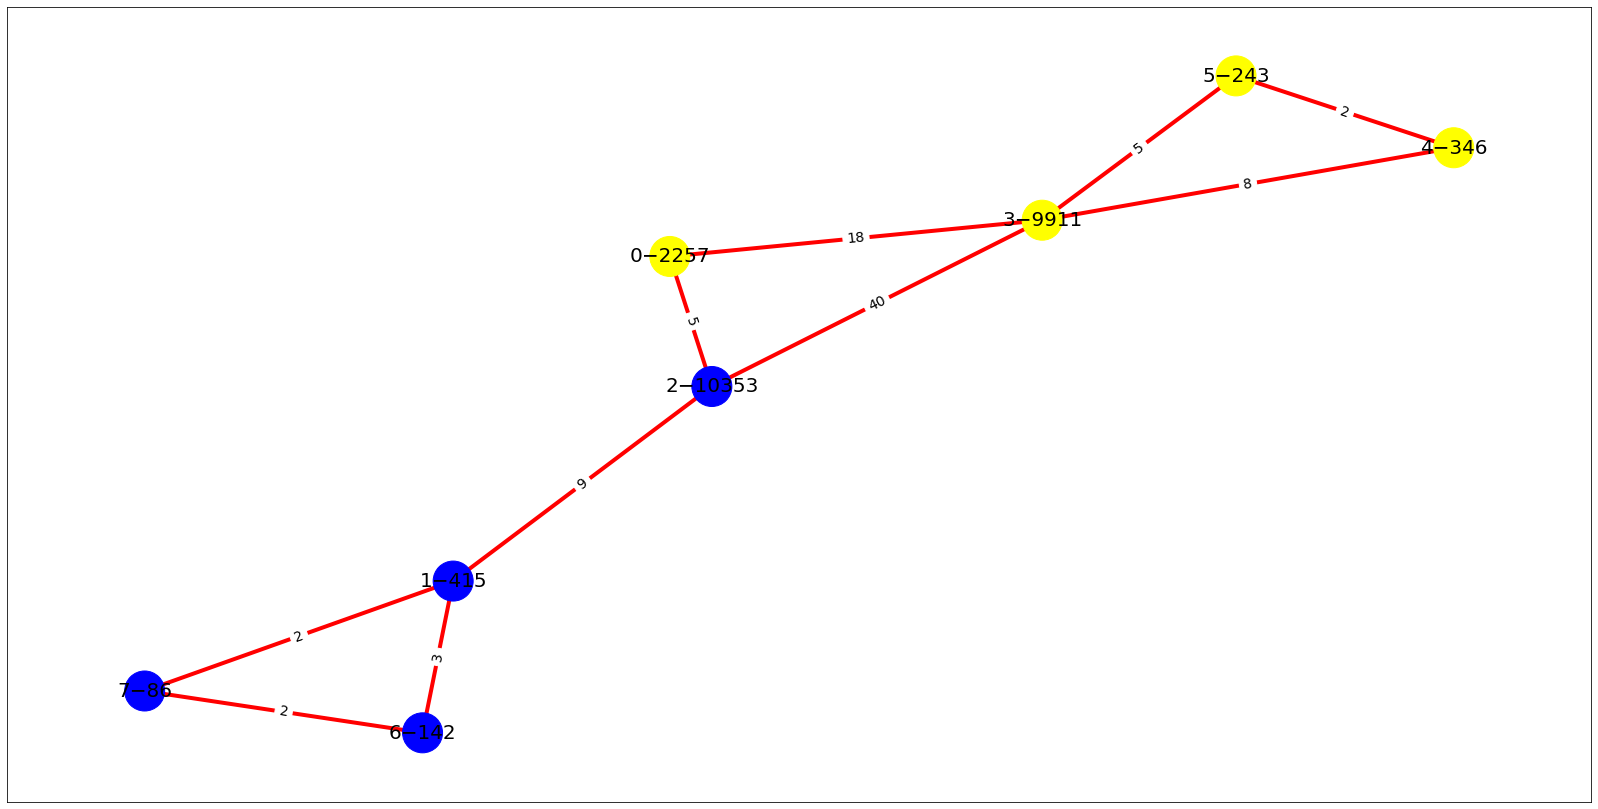

In [6]:
draw_graph(use_network(8), ''.join(str(int(x)) for x in result.x[::-1]))

In [7]:
qaoa_optimizer = MinimumEigenOptimizer(QAOA(quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")),reps=3))
result = qaoa_optimizer.solve(graph_partition.to_quadratic_program())

print("solution:", graph_partition.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [[1, 2, 6, 7], [0, 3, 4, 5]]
time: 153.85221695899963


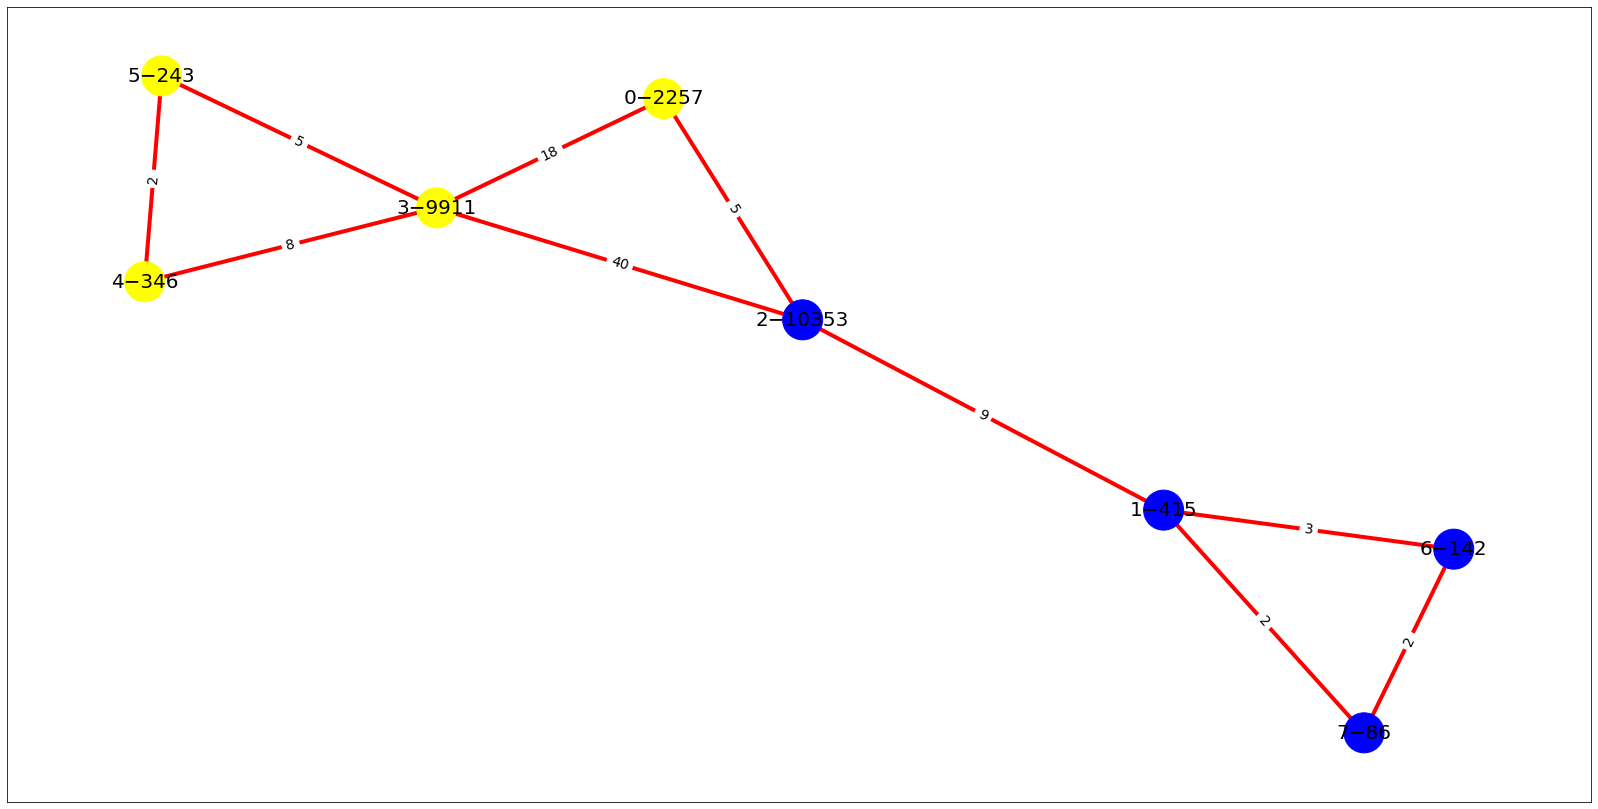

In [8]:
draw_graph(use_network(8), ''.join(str(int(x)) for x in result.x[::-1]))

### Cliques

In [9]:
from qiskit_optimization.applications.clique import Clique

clique = Clique(use_network(8), size = 5)

qaoa_optimizer = MinimumEigenOptimizer(QAOA(quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")), reps = 3))

result = qaoa_optimizer.solve(clique.to_quadratic_program())

print("solution:", clique.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [0, 1, 2, 3, 6]
time: 163.10875868797302


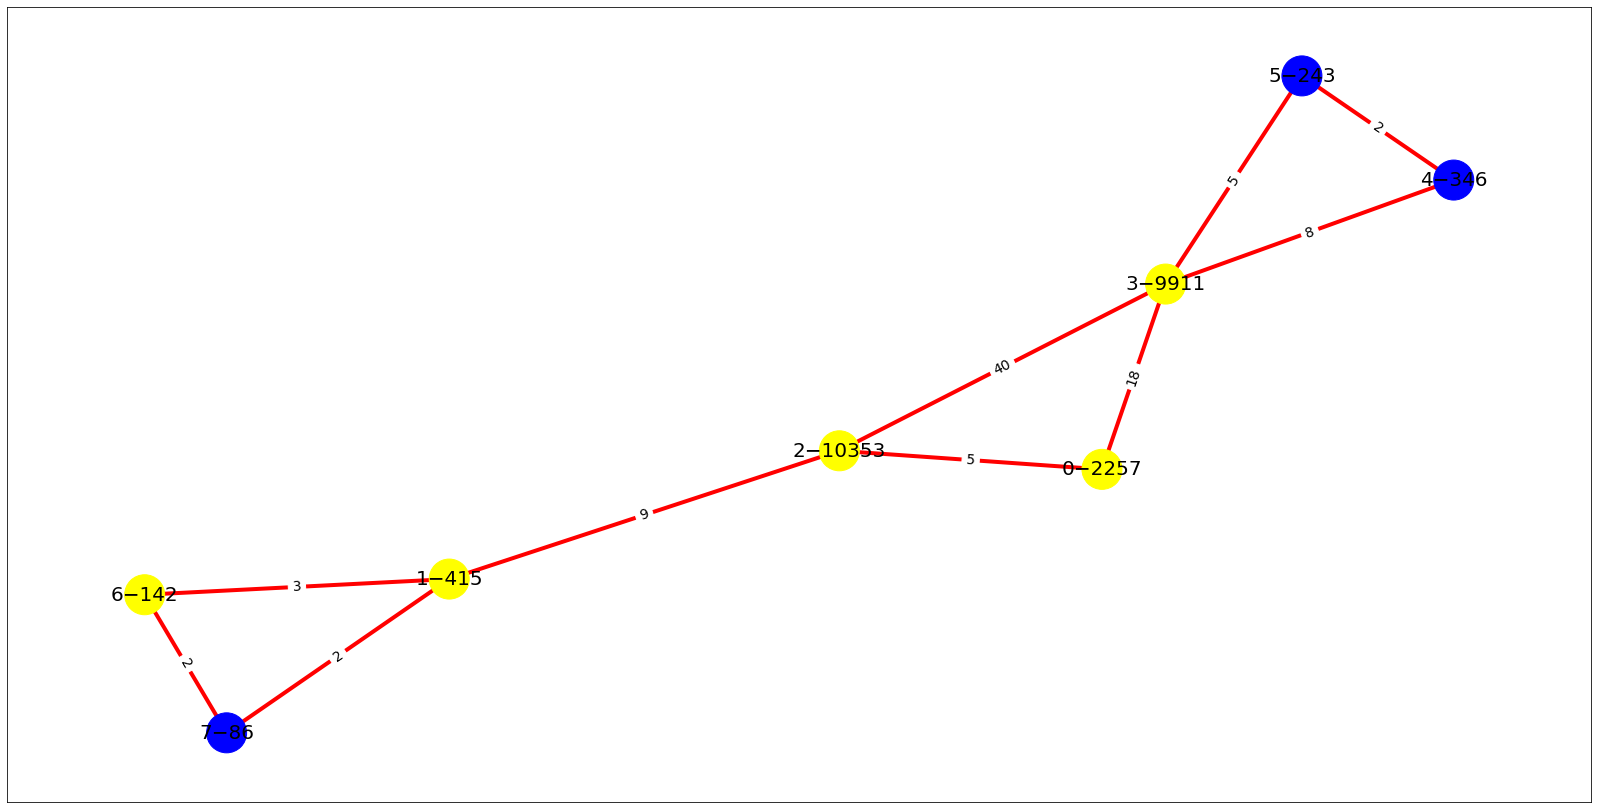

In [10]:
draw_graph(use_network(8), ''.join(str(int(x)) for x in result.x[::-1]))

#### Stable Set

In [11]:
from qiskit_optimization.applications import StableSet
stable_set = StableSet(use_network(8))
qaoa_optimizer = MinimumEigenOptimizer(QAOA(quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")), reps = 3))

result = qaoa_optimizer.solve(clique.to_quadratic_program())

print("solution:", stable_set.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [0, 2, 3, 4, 5]
time: 231.81854128837585


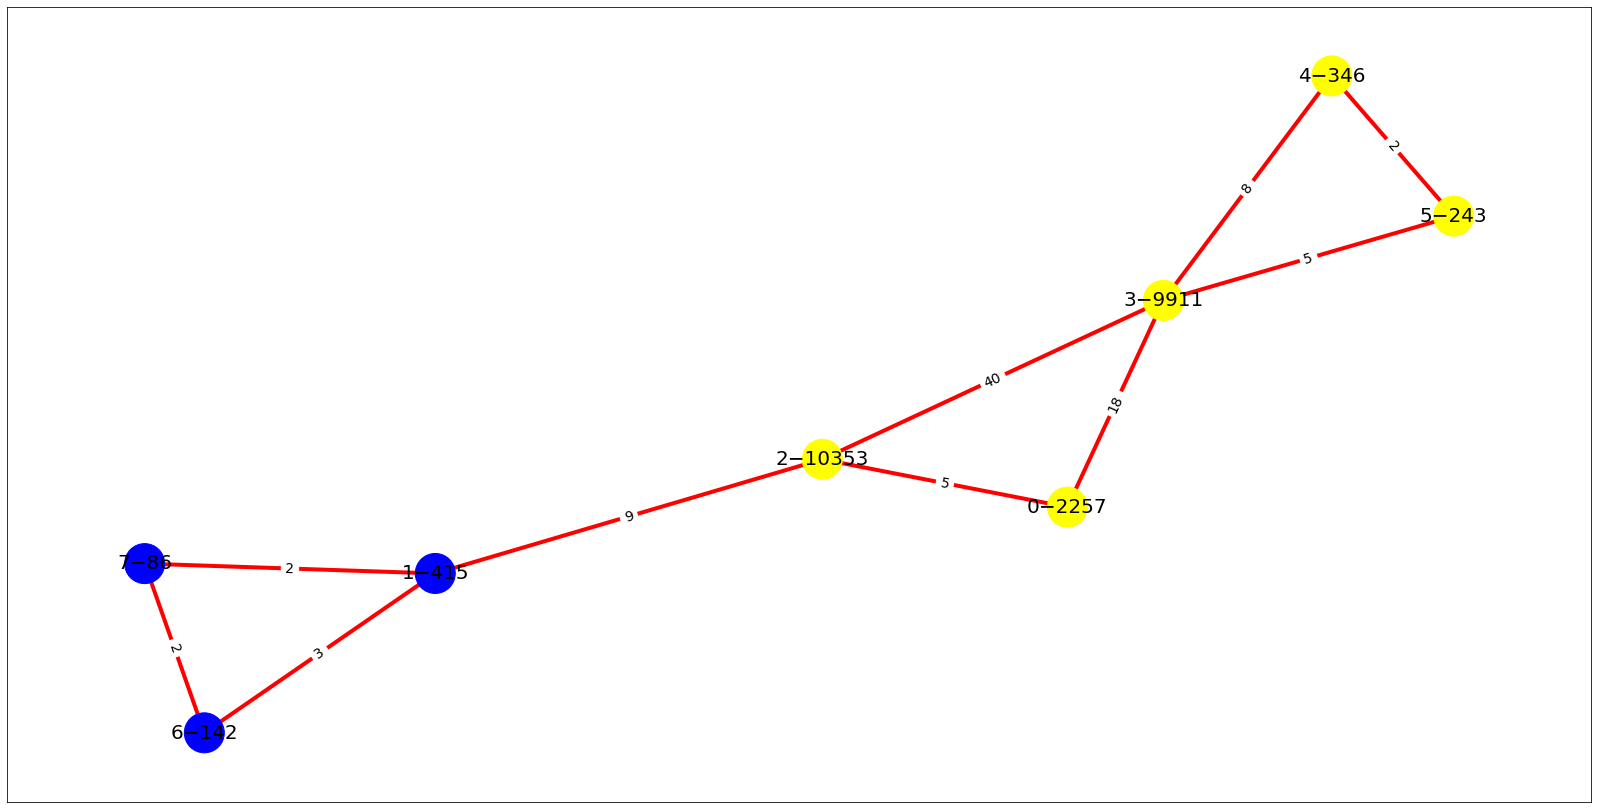

In [12]:
draw_graph(use_network(8), ''.join(str(int(x)) for x in result.x[::-1]))

### Knapsack

In [20]:
data = pd.read_csv("data/hero_network.csv")

In [21]:
size = 8
heroes = select_heroes(size)

# count the overall appearences of the heroes
count_series1 = data.groupby(['hero1']).size()
count_series2 = data.groupby(['hero2']).size()
total_appearences = dict(sorted([row for row in count_series1.add(count_series2, fill_value=0).to_dict().items() if row[0] in heroes.keys()], key=lambda row: heroes[row[0]]))
total_appearences

{'MEDUSA/MEDUSALITH AM': 2257.0,
 'ARCLIGHT/PHILLIPA SO': 415.0,
 'WOLVERINE/LOGAN ': 10353.0,
 'SCARLET WITCH/WANDA ': 9911.0,
 'ARAGORN': 346.0,
 'OVERMIND/GROM': 243.0,
 'BATTLEAXE/': 142.0,
 'ION/': 86.0}

In [23]:
relations = data[(data.hero1.isin(heroes.keys())) & (data.hero2.isin(
heroes.keys()))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns)

count_network1 = relations.groupby(['hero1']).size()
count_network2 = relations.groupby(['hero2']).size()
network_appearences = dict(sorted([row for row in count_network1.add(count_network2, fill_value=0).to_dict().items()], key=lambda row: select_heroes(size)[row[0]]))
network_appearences

{'MEDUSA/MEDUSALITH AM': 23.0,
 'ARCLIGHT/PHILLIPA SO': 14.0,
 'WOLVERINE/LOGAN ': 54.0,
 'SCARLET WITCH/WANDA ': 71.0,
 'ARAGORN': 10.0,
 'OVERMIND/GROM': 7.0,
 'BATTLEAXE/': 5.0,
 'ION/': 4.0}

In [24]:
from qiskit_optimization.applications import Knapsack

max_weight=10000

knapsack = Knapsack(values=list(network_appearences.values()),weights=list(total_appearences.values()),max_weight=max_weight)

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator"))))

result = qaoa_optimizer.solve(knapsack.to_quadratic_program())
print("solution:", knapsack.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [3, 7]
time: 1135.2010607719421


In [39]:
l = list(knapsack.interpret(result))
new_l = []
for i in list(select_heroes(8).values()):
    for j in l:
        if i == j:
            print(list(select_heroes(8).keys())[i])
            new_l.append(list(select_heroes(8).keys())[i])

SCARLET WITCH/WANDA 
ION/


In [40]:
new_l

['SCARLET WITCH/WANDA ', 'ION/']